In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/CSE512/HW5'

Mounted at /content/gdrive
/content/gdrive/My Drive/CSE512/HW5


In [2]:
def gaussfn(x,mu,C):
    d = mu.shape[0]  # Dimensionality
    if x.ndim == 1:  # Single point, shape (d,)
        x = x.reshape(-1, 1)  # Convert to (d, 1)
    diff = x - mu.reshape(-1, 1)  # Subtract mean, shape (d, m)
    C_inv = np.linalg.inv(C)  # Inverse of covariance matrix
    det_C = np.linalg.det(C)  # Determinant of covariance matrix
    exp_term = -0.5 * np.sum(diff * (C_inv @ diff), axis=0)  # Mahalanobis distance
    return (1 / np.sqrt((2 * np.pi) ** d * det_C)) * np.exp(exp_term)

In [10]:
data = sio.loadmat('mnist.mat')
X = data['trainX'].astype(float)/255
y = data['trainY'][0,:]
idx = np.less(y,3)
X = X[idx,:]
y = y[idx]
X = X[:1000,:]
y = y[:1000]


u,s,v = np.linalg.svd(X,0)
print(u.shape,s.shape,v.shape)
X = u[:,:2]

m,n = X.shape

(1000, 784) (784,) (784, 784)


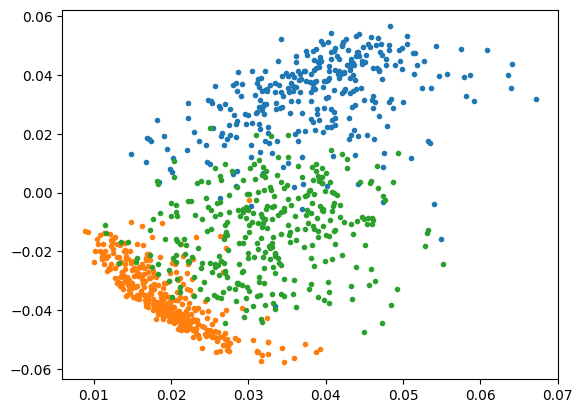

In [4]:
def plot_label(y):
    for i in range(len(np.unique(y))):
        plt.plot(X[np.equal(y,i),0],X[np.equal(y,i),1],marker='.',linewidth=0)
def plot_gauss(alpha,mu,Clist):
    xg=np.linspace(0,.05,100)
    yg=np.linspace(-.05,.05,100)
    [xm,ym] = np.meshgrid(xg,yg)
    zm = [xm*0 for k in range(K)]
    for i in range(len(xg)):
        for j in range(len(xg)):
            xxg = np.array([xm[i,j],ym[i,j]])
            for k in range(K):
                zm[k][i,j] = alpha[k]*gaussfn(xxg,mu[:,k],Clist[k])
    for k in range(K):
        #plt.subplot(2,3,k+1)
        plt.contour(xm,ym,zm[k],alpha=.5)

plot_label(y)

In [11]:


def get_pi(pi,alpha, mu, Clist):
    K = len(Clist)
    for k in range(K):
        pi[:, k] = alpha[k] * gaussfn(X.T, mu[:, k], Clist[k])
    pi = pi / np.sum(pi, axis=1, keepdims=True)  # Normalize
    return pi

def get_alpha(pi,alpha, mu, Clist):
    return np.mean(pi, axis=0)

def get_mu(pi,alpha, mu, Clist):
    return (X.T @ pi) / np.sum(pi, axis=0)

def get_Clist(pi,alpha, mu, Clist):
    K = len(Clist)
    for k in range(K):
        diff = X.T - mu[:, k].reshape(-1, 1)
        Clist[k] = (pi[:, k] * diff) @ diff.T / np.sum(pi[:, k])
        #Clist[k] += 0.1 * np.eye(n) #b
    return Clist


<ipython-input-4-a056c77d34f3>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zm[k][i,j] = alpha[k]*gaussfn(xxg,mu[:,k],Clist[k])


Text(0.5, 1.0, 'True Labels with Gaussian Contours')

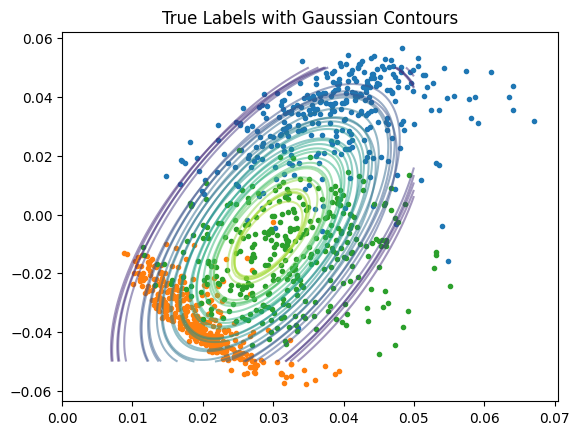

In [12]:

K = 5
mu = np.random.rand(n,K)
pi = np.zeros((m,K))
alpha = np.ones(K)/K
Clist = [np.eye(n) for k in range(K)]

for iter in range(10):
    pi = get_pi(pi,alpha, mu, Clist)
    alpha = get_alpha(pi,alpha, mu, Clist)
    mu = get_mu(pi,alpha, mu, Clist)
    Clist = get_Clist(pi,alpha, mu, Clist)


plot_label(y)
plot_gauss(alpha, mu, Clist)
plt.title("True Labels with Gaussian Contours")

<ipython-input-4-a056c77d34f3>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zm[k][i,j] = alpha[k]*gaussfn(xxg,mu[:,k],Clist[k])


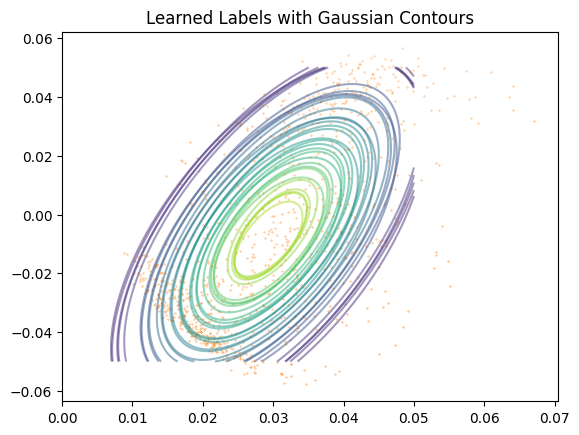

In [15]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
yhat = np.argmax(pi,axis=1)

for j in range(m):
    k = yhat[j]
    plt.plot(X[j,0],X[j,1],marker='.',linewidth=0,color=colors[k],markersize=pi[j,k]*2)

plot_gauss(alpha, mu, Clist)
plt.title("Learned Labels with Gaussian Contours")
plt.show()

1
1
1
1
1
1
1
1
1
1


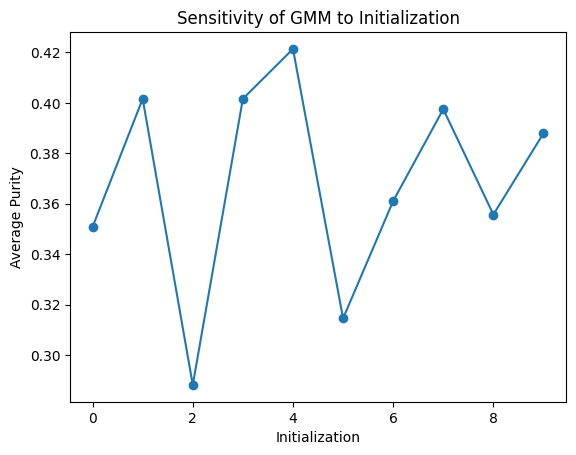

In [ ]:
X = data['trainX'].astype(float) / 255
X = X[:, ::4]
y = data['trainY'][0, :]
m,n = X.shape
K = 5

def compute_purity(y, pi):
    print(1)
    """
    Compute the average purity of the clustering.
    y: True labels, shape (m,)
    pi: Responsibilities, shape (m, K)
    Returns: Average purity
    """
    yhat = np.argmax(pi, axis=1)  # Predicted cluster for each sample
    total_purity = 0

    for k in range(K):
        cluster_indices = (yhat == k)
        if np.sum(cluster_indices) == 0:
            continue
        true_labels = y[cluster_indices]
        most_frequent_label_count = np.max(np.bincount(true_labels))
        total_purity += most_frequent_label_count / len(y)

    return total_purity

n_trials = 10
n_iterations = 100
purities = []

for trial in range(n_trials):
    mu = np.random.rand(n, K)  # Random initialization of means
    pi = np.zeros((m, K))
    alpha = np.ones(K) / K
    Clist = [np.eye(n) for _ in range(K)]

    for _ in range(n_iterations):
        pi = get_pi(pi, alpha, mu, Clist)
        alpha = get_alpha(pi, alpha, mu, Clist)
        mu = get_mu(pi, alpha, mu, Clist)
        Clist = get_Clist(pi, alpha, mu, Clist)

    purity = compute_purity(y, pi)
    purities.append(purity)

# Plot average purity
plt.plot(range(n_trials), purities, marker='o')
plt.xlabel("Initialization")
plt.ylabel("Average Purity")
plt.title("Sensitivity of GMM to Initialization")
plt.show()

In [ ]:
import torch
X = data['trainX'].astype(float) / 255
X = X[:, ::4]
y = data['trainY'][0, :]
X = torch.tensor(X, dtype=torch.float32).cuda()  # Move to GPU
y = torch.tensor(y, dtype=torch.int64).cuda()
m,n = X.shape
K = 5

def gaussfn(x,mu,C):
    d = mu.shape[0]  # Dimensionality
    if x.ndim == 1:  # Single point, shape (d,)
        x = x.reshape(-1, 1)  # Convert to (d, 1)
    diff = x - mu.reshape(-1, 1)  # Subtract mean, shape (d, m)
    #C_inv = np.linalg.inv(C)  # Inverse of covariance matrix
    #det_C = np.linalg.det(C)  # Determinant of covariance matrix
    #exp_term = -0.5 * np.sum(diff * (C_inv @ diff), axis=0)  # Mahalanobis distance
    #return (1 / np.sqrt((2 * np.pi) ** d * det_C)) * np.exp(exp_term)

    det_C = torch.linalg.det(C)  # Add small diagonal for stability
    C_inv = torch.linalg.inv(C)
    exp_term = -0.5 * torch.sum(diff * (C_inv @ diff), axis=0)
    return (1 / torch.sqrt((2 * torch.pi) ** d * det_C)) * torch.exp(exp_term)

def get_pi(pi,alpha, mu, Clist):
    K = len(Clist)
    for k in range(K):
        pi[:, k] = alpha[k] * gaussfn(X.T, mu[:, k], Clist[k])
    pi = pi / torch.sum(pi, axis=1, keepdims=True)  # Normalize
    return pi

def get_alpha(pi,alpha, mu, Clist):
    return torch.mean(pi, axis=0)

def get_mu(pi,alpha, mu, Clist):
    return (X.T @ pi) / torch.sum(pi, axis=0)
    #return (X.T @ pi) / np.sum(pi, axis=0)

def get_Clist(pi,alpha, mu, Clist):
    K = len(Clist)
    for k in range(K):
        diff = X.T - mu[:, k].reshape(-1, 1)
        Clist[k] = (pi[:, k] * diff) @ diff.T / torch.sum(pi[:, k])
        Clist[k] += 0.1 * torch.eye(n).cuda()
        #Clist[k] = (pi[:, k] * diff) @ diff.T / np.sum(pi[:, k])
        #Clist[k] += 0.1 * np.eye(n) #b
    return Clist

In [ ]:

def compute_purity(y, pi):
    print(1)
    """
    Compute the average purity of the clustering.
    y: True labels, shape (m,)
    pi: Responsibilities, shape (m, K)
    Returns: Average purity
    """
    yhat = torch.argmax(pi, dim=1).cpu().numpy()
    #yhat = np.argmax(pi, axis=1)  # Predicted cluster for each sample
    total_purity = 0
    unique_clusters = torch.unique(yhat)
    for k in range(unique_clusters):
        cluster_indices = (yhat == k)
        most_frequent = y[cluster_indices].bincount().max().item()
        purity += most_frequent
    return purity / len(y)
        #if np.sum(cluster_indices) == 0:
        #    continue
        #true_labels = y[cluster_indices]
        #most_frequent_label_count = np.max(np.bincount(true_labels))
        #total_purity += most_frequent_label_count / len(y)

    #return total_purity

n_trials = 10
n_iterations = 100
purities = []

for trial in range(n_trials):
    mu = torch.rand((n, K), dtype=torch.float32)  # Means
    alpha = torch.ones(K, dtype=torch.float32) / K  # Mixture weights
    Clist = [torch.eye(n, dtype=torch.float32) for _ in range(K)]  # Covariances
    pi = torch.zeros((m, K), dtype=torch.float32)
    #mu = np.random.rand(n, K)  # Random initialization of means
    #pi = np.zeros((m, K))
    #alpha = np.ones(K) / K
    #Clist = [np.eye(n) for _ in range(K)]

    for _ in range(n_iterations):
        pi = get_pi(pi, alpha, mu, Clist)
        alpha = get_alpha(pi, alpha, mu, Clist)
        mu = get_mu(pi, alpha, mu, Clist)
        Clist = get_Clist(pi, alpha, mu, Clist)

    purity = compute_purity(y, pi)
    purities.append(purity)

# Plot average purity
plt.plot(range(n_trials), purities, marker='o')
plt.xlabel("Initialization")
plt.ylabel("Average Purity")
plt.title("Sensitivity of GMM to Initialization")
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!